In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
import pandas as pd
from nltk.stem.wordnet import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")


df = pd.read_csv("C:/ML/python/data/Suicide_Ideation_Dataset(Twitter-based).csv",delimiter=',')


df.head(10)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\katsa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\katsa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\katsa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Tweet,Suicide
0,making some lunch,Not Suicide post
1,@Alexia You want his money.,Not Suicide post
2,@dizzyhrvy that crap took me forever to put to...,Potential Suicide post
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,Not Suicide post
4,Trying out &quot;Delicious Library 2&quot; wit...,Not Suicide post
5,"@ValenValdez Oh, that's good to hear. But is i...",Not Suicide post
6,@mcm180 u've got a list for fellow #hotties? Y...,Not Suicide post
7,@jakepaul @jamescharles @LoganPaul Just becaus...,Potential Suicide post
8,time for some warsaw beer garden chilling,Not Suicide post
9,I hate my life lmao I hope I die soon or sumn ...,Potential Suicide post


In [2]:
df.isna().sum()

Tweet      2
Suicide    0
dtype: int64

In [3]:
df.dropna(inplace=True)
df.duplicated().sum()

8

In [4]:
df.drop_duplicates(inplace=True)

<Axes: ylabel='count'>

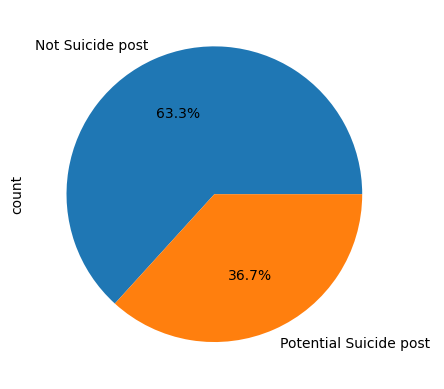

In [5]:

df['Suicide'].value_counts().plot(kind='pie',autopct='%1.1f%%')

In [6]:
df['class'] = df['Suicide'].map({"Not Suicide post":0,"Potential Suicide post ":1})

df['class'].value_counts()

class
0    1124
1     653
Name: count, dtype: int64

In [7]:
PUNC = string.punctuation


def clean_text(text):
    
    
    text = str(text).lower()
    
    text = re.sub(r'<.*?>+', '',text)
    
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    text = re.sub(r'\d', '',text)
    text = re.sub('[%s]' % re.escape(PUNC), '',text)
    
    text = re.sub(' +', ' ', text)
    
    text = re.sub('rt', '',text)

    
    
    return text


df['Tweet'] = df['Tweet'].apply(clean_text)
df['Tweet'].head(10)

0                                    making some lunch
1                            alexia you want his money
2    dizzyhrvy that crap took me forever to put tog...
3    jnaylor kiwitweets hey jer since when did you ...
4    trying out quotdelicious library quot with mix...
5    valenvaldez oh thats good to hear but is it ov...
6    mcm uve got a list for fellow hotties you gonn...
7    jakepaul jamescharles loganpaul just because s...
8            time for some warsaw beer garden chilling
9    i hate my life lmao i hope i die soon or sumn ...
Name: Tweet, dtype: object

In [8]:
sw = set(stopwords.words("english"))


def remove_stopwords(text):
    tokens = word_tokenize(text)
    cleaned_tokens = [word for word in tokens if word.lower() not in sw]
    return " ".join(cleaned_tokens)

df['Tweet'] = df['Tweet'].apply(remove_stopwords)


In [9]:

lemmatizer = WordNetLemmatizer()

def lemmatization(text):
    tokens = word_tokenize(text)
    lemma_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemma_tokens)

df['Tweet'] = df['Tweet'].apply(lemmatization)

In [10]:
import contractions

def expand_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text

df['Tweet'] = df['Tweet'].apply(expand_contractions)


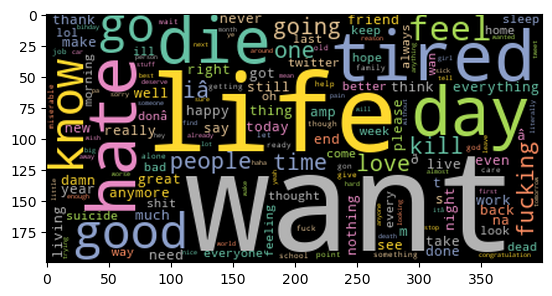

In [11]:
text = " ".join(i for i in df['Tweet'])


from wordcloud import WordCloud
import matplotlib.pyplot as plt


wc = WordCloud(colormap='Set2',collocations=False).generate(text)
plt.imshow(wc,interpolation='blackman')
plt.show()


In [12]:
from textblob import TextBlob
blob = TextBlob(text)


In [13]:
for sentiment in blob.sentiment:
    print(sentiment)

0.02002812633562074
0.5812332188200663


In [14]:

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()


X = df['Tweet']
X = cv.fit_transform(X).toarray()
y = df['class']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)

from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB

MNB = MultinomialNB()
GNB = GaussianNB()
BNB = BernoulliNB()

from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier
lr = LogisticRegression()
PA = PassiveAggressiveClassifier()



from sklearn.metrics import accuracy_score,classification_report

def evaluate_bayes(X_train,X_test,y_train,y_test,model):
    model = model.fit(X_train,y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test,pred)
    clf_rpt = classification_report(y_test,pred)
    print(f'{model.__class__.__name__}, --Accuracy-- {acc*100:.2f}%; --Classification Report-- {clf_rpt}')
    return pred


MNB_pred = evaluate_bayes(X_train, X_test, y_train, y_test, MNB)
GNB_pred = evaluate_bayes(X_train, X_test, y_train, y_test, GNB)
BNB_pred = evaluate_bayes(X_train, X_test, y_train, y_test, BNB)
PA_pred = evaluate_bayes(X_train, X_test, y_train, y_test, PA)
lr_pred = evaluate_bayes(X_train, X_test, y_train, y_test, lr)


MultinomialNB, --Accuracy-- 83.43%; --Classification Report--               precision    recall  f1-score   support

           0       0.94      0.77      0.85       211
           1       0.74      0.92      0.82       145

    accuracy                           0.83       356
   macro avg       0.84      0.85      0.83       356
weighted avg       0.86      0.83      0.84       356

GaussianNB, --Accuracy-- 64.33%; --Classification Report--               precision    recall  f1-score   support

           0       0.86      0.48      0.61       211
           1       0.54      0.88      0.67       145

    accuracy                           0.64       356
   macro avg       0.70      0.68      0.64       356
weighted avg       0.73      0.64      0.64       356

BernoulliNB, --Accuracy-- 80.34%; --Classification Report--               precision    recall  f1-score   support

           0       0.75      0.99      0.86       211
           1       0.97      0.53      0.69       145

 

In [15]:
X = df['Tweet']
y = df['class']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.15,random_state=1)


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences,to_categorical

tokenizer = Tokenizer()


tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print(len(word_index))


5035


In [16]:

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


max_length = 0
for sequence in X_train:
    sequence_length = len(sequence)
    if sequence_length > max_length:
        max_length = sequence_length


print("max length",max_length)

X_train = pad_sequences(X_train,max_length,padding='post')
X_test = pad_sequences(X_test,max_length,padding='post')


max length 100


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,Bidirectional,Dropout,SpatialDropout1D

RNN = Sequential()
RNN.add(Embedding(input_dim=len(word_index)+1, output_dim=150, input_length=max_length))
RNN.add(SpatialDropout1D(0.2))
RNN.add(Bidirectional(LSTM(50, dropout=0.1, recurrent_dropout=0.1)))
RNN.add(Dropout(0.1))
RNN.add(Dense(1))
RNN.add(Dropout(0.1))
RNN.add(Dense(2, activation='sigmoid'))
RNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = RNN.fit(X_train,y_train,batch_size=128,epochs=10,validation_data=(X_test, y_test))

print("Maximum Training Accuracy: ",max(history.history['accuracy']))
print("Maximum Validation Accuracy: ",max(history.history['val_accuracy']))

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 316ms/step - accuracy: 0.6226 - loss: 0.6582 - val_accuracy: 0.5693 - val_loss: 0.6413
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - accuracy: 0.6778 - loss: 0.5752 - val_accuracy: 0.7528 - val_loss: 0.5300
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - accuracy: 0.8193 - loss: 0.4687 - val_accuracy: 0.8202 - val_loss: 0.4151
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 0.8952 - loss: 0.3258 - val_accuracy: 0.8502 - val_loss: 0.3378
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - accuracy: 0.9171 - loss: 0.2111 - val_accuracy: 0.8876 - val_loss: 0.2808
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.9438 - loss: 0.1566 - val_accuracy: 0.8989 - val_loss: 0.2900
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.9480 - loss: 0.1239 - val_accuracy: 0.8951 - val_loss: 0.3379
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - accuracy: 0.9550 - loss: 0.1188 - val_accuracy: 0

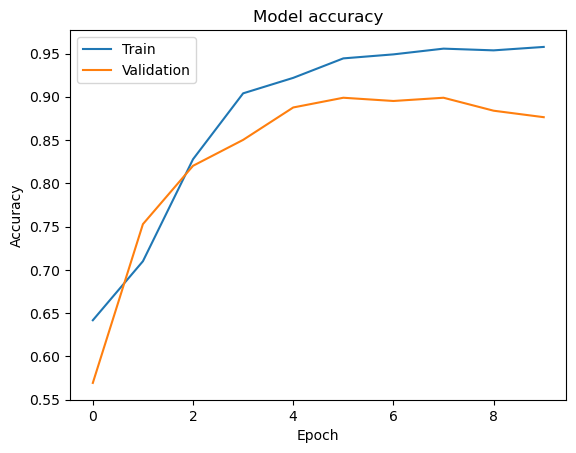

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



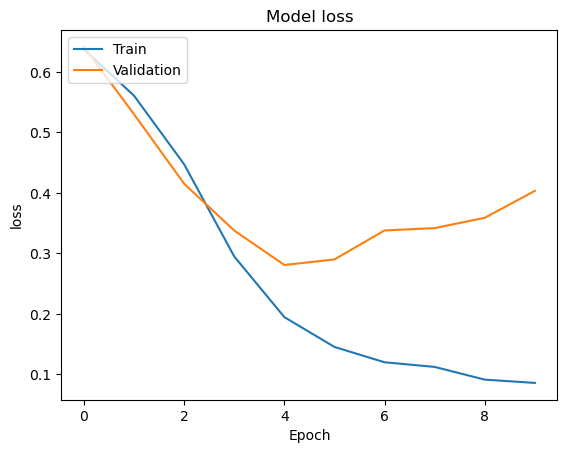

In [19]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
